In [1]:
import pandas as pd
import numpy as np

import torch
import torchvision

import matplotlib.pylab as plt
import seaborn as sns

import os
import time

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from tqdm.auto import tqdm

from shutil import move

from PIL import Image

from sklearn.model_selection import train_test_split

from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Изучаем dataframe

In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/Tirads/classes.xlsx')
df.shape

(48, 2)

In [ ]:
df['Узел ЩЖ, TIRADS'].value_counts()

5    22
4    13
3    10
2     3
Name: Узел ЩЖ, TIRADS, dtype: int64

In [ ]:
df.columns = ['index', 'Tirads']

In [ ]:
df = df.set_index('index')
df.head()

,Tirads
index,
178,4
179,5
180,3
181,5
182,3


In [ ]:
df = df.squeeze()

In [ ]:
df.head()

index
178    4
179    5
180    3
181    5
182    3
Name: Tirads, dtype: int64

In [ ]:
df.value_counts()

5    22
4    13
3    10
2     3
Name: Tirads, dtype: int64

In [ ]:
df[180]

3

# Извлечение данных из TIFF

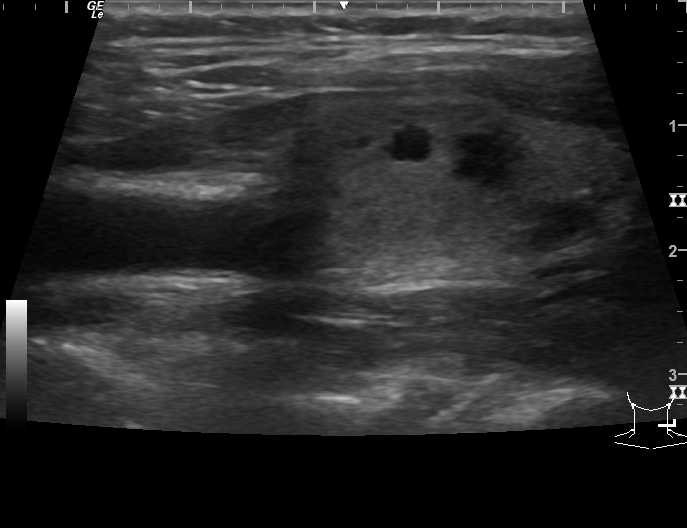

In [4]:
example = "/content/gdrive/MyDrive/Tirads/data/178/178_TIRADS4_long.tif"
Image.open(example)

In [ ]:
path='/content/gdrive/MyDrive/Tirads'

In [ ]:
def parse_tif(filePath: str, savePath: str):
  img = Image.open(filePath)
  #print(img.n_frames)
  name = filePath.split('/')[-1][:-4]
  for i in range (0, img.n_frames, 5):
      img.seek(i)
      newName = f'{name}_{i}.tif'
      #print(os.path.join(savePath, newName))
      img.save(os.path.join(savePath, newName))
      #print(f'{name}_{i}.tif')

In [ ]:
for subdir, dirs, files in os.walk(os.path.join(path, 'data')):
    for file in files:
      filePath=os.path.join(subdir, file)
      if not('mask' in filePath) and not('add' in filePath):
        parse_tif(filePath, os.path.join(path, 'Extracted'))

# Создание тренировочной и тестовой выборки

In [ ]:
path='/content/gdrive/MyDrive/Tirads'

In [ ]:
pathExtracted = os.path.join(path, 'Extracted')
files = []
classes = []
for fileName in os.listdir(pathExtracted):
  filePath = os.path.join(pathExtracted, fileName)
  if os.path.isfile(filePath):
    index = int(fileName.split('_')[0])
    files.append(filePath)
    classes.append(df[index])

In [ ]:
data = {
    'FilePath': files,
    'Tirads': classes
}
dfExtracted = pd.DataFrame(data)

In [ ]:
dfExtracted.head()

,FilePath,Tirads
0,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,3
1,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,3
2,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,3
3,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,3
4,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,3


In [ ]:
def classify(Tirads):
  if Tirads == 5:
    return 1
  return 0

In [ ]:
dfExtracted['Tirads'] = dfExtracted['Tirads'].apply(classify)
dfExtracted.head()

,FilePath,Tirads
0,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0
1,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0
2,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0
3,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0
4,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0


In [ ]:
dfExtracted['Tirads'].value_counts()

0    831
1    675
Name: Tirads, dtype: int64

In [ ]:
dfExtracted.to_csv('/content/gdrive/MyDrive/Tirads/dataframe.csv', index=False)

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Tirads/dataframe.csv')
df.shape

(1506, 2)

In [ ]:
df.head()

,FilePath,Tirads
0,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0
1,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0
2,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0
3,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0
4,/content/gdrive/MyDrive/Tirads/Extracted/180_T...,0


In [ ]:
df['Tirads'].value_counts()

0    831
1    675
Name: Tirads, dtype: int64

In [ ]:
train, test = train_test_split(df, test_size=0.33, random_state=42, stratify=df['Tirads'])


In [ ]:
train.Tirads.value_counts()

0    557
1    452
Name: Tirads, dtype: int64

In [ ]:
test.Tirads.value_counts()

0    274
1    223
Name: Tirads, dtype: int64

In [ ]:
count = 0
for i in range(len(train)):
  x = train.iloc[i, 0]
  y = train.iloc[i, 1]
  fileName = x.split('/')[-1]
  if y == 0:
    move(x, os.path.join(path, 'Extracted', 'train', 'OTHER', fileName))
  elif y == 1:
    move(x, os.path.join(path, 'Extracted', 'train', 'TIRADS5', fileName))


In [ ]:
for i in range(len(test)):
  x = test.iloc[i, 0]
  y = test.iloc[i, 1]
  fileName = x.split('/')[-1]
  if y == 0:
    move(x, os.path.join(path, 'Extracted', 'test', 'OTHER', fileName))
  elif y == 1:
    move(x, os.path.join(path, 'Extracted', 'test', 'TIRADS5', fileName))

# Подготовка данных для модели

In [ ]:
train_dir = '/content/gdrive/MyDrive/Tirads/Extracted/train'
test_dir = '/content/gdrive/MyDrive/Tirads/Extracted/test'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
weights = torchvision.models.ResNet18_Weights.DEFAULT
weights

ResNet18_Weights.IMAGENET1K_V1

In [ ]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
transform = weights.transforms()

In [ ]:
train_data = ImageFolder(train_dir, transform=transforms_train)
test_data = ImageFolder(test_dir, transform=transforms_test)
datasets = {
    'train': train_data,
    'test': test_data
}

In [ ]:
class_names = train_data.classes
class_names

['OTHER', 'TIRADS5']

In [ ]:
train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False
)

dataloaders = {
    'train': train_dataloader,
    'test': test_dataloader
}

In [ ]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 1009, 'test': 497}

# Resnet 18

In [ ]:
model = torchvision.models.resnet18(weights=weights).to(device)

In [ ]:
num_features = model.fc.in_features
num_features


512

In [ ]:
class FC_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(512, 64)
        self.linear2=nn.Linear(64, 2)

    def forward(self,x):
        x = nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [ ]:
model_ = FC_layer().to(device)
model_

FC_layer(
  (linear1): Linear(in_features=512, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
model.fc = model_
model.fc

FC_layer(
  (linear1): Linear(in_features=512, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
for param in model.parameters():
        param.requires_grad = False
for param in model.fc.parameters():
        param.requires_grad = True

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

epochs = 20

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
      model.train()
      for image,label in train_dataloader:
          image = image.to(device)
          label = label.to(device)
          optimizer.zero_grad()
          y_pred = model.forward(image)
          loss = loss_fn(y_pred,label)
          loss.backward()
          optimizer.step()
          val, index_ = torch.max(y_pred,axis=1)
          running_score += torch.sum(index_ == label.data).item()
          running_loss += loss.item()

      epoch_score = running_score/len(train_dataloader.dataset)
      epoch_loss = running_loss/len(train_dataloader.dataset)
      train_loss.append(epoch_loss)
      train_accuracy.append(epoch_score)
      print("Training loss: {:.4f}, accuracy: {:.4f}".format(epoch_loss,epoch_score))
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_dataloader:
                image = image.to(device)
                label = label.to(device)
                optimizer.zero_grad()
                y_pred = model.forward(image)
                loss = loss_fn(y_pred,label)
                running_loss += loss.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

          epoch_score = running_score/len(test_dataloader.dataset)
          epoch_loss = running_loss/len(test_dataloader.dataset)
          val_loss.append(epoch_loss)
          val_accuracy.append(epoch_score)
          print("Validation loss: {:.4f}, accuracy: {:.4f}".format(epoch_loss,epoch_score))


epoch 1/20
Training loss: 0.0220, accuracy: 0.5431
Validation loss: 0.0226, accuracy: 0.5111
epoch 2/20
Training loss: 0.0221, accuracy: 0.5471
Validation loss: 0.0224, accuracy: 0.5392
epoch 3/20
Training loss: 0.0217, accuracy: 0.5441
Validation loss: 0.0230, accuracy: 0.5513
epoch 4/20
Training loss: 0.0216, accuracy: 0.5719
Validation loss: 0.0221, accuracy: 0.5493
epoch 5/20
Training loss: 0.0217, accuracy: 0.5540
Validation loss: 0.0220, accuracy: 0.5453
epoch 6/20
Training loss: 0.0215, accuracy: 0.5550
Validation loss: 0.0221, accuracy: 0.5453
epoch 7/20
Training loss: 0.0215, accuracy: 0.5738
Validation loss: 0.0218, accuracy: 0.5734
epoch 8/20
Training loss: 0.0214, accuracy: 0.5689
Validation loss: 0.0219, accuracy: 0.5694
epoch 9/20
Training loss: 0.0212, accuracy: 0.5818
Validation loss: 0.0217, accuracy: 0.5694
epoch 10/20
Training loss: 0.0211, accuracy: 0.5867
Validation loss: 0.0217, accuracy: 0.5835
epoch 11/20
Training loss: 0.0211, accuracy: 0.5798
Validation loss: 

# Resnet18 (2.0)

In [ ]:
model = torchvision.models.resnet18(weights=weights).to(device)

In [ ]:
count = 0
for child in model.children():
      count+=1
print(count)


10


In [ ]:
count = 0
for child in model.children():
  count+=1
  if count < 7:
    for param in child.parameters():
        param.requires_grad = False


In [ ]:
num_features = model.fc.in_features
num_features

512

In [ ]:
class FC_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(512, 64)
        self.linear2=nn.Linear(64, 2)

    def forward(self,x):
        x = nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [ ]:
model.fc = FC_layer().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

epochs = 20

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
      model.train()
      for image,label in train_dataloader:
          image = image.to(device)
          label = label.to(device)
          optimizer.zero_grad()
          y_pred = model.forward(image)
          loss = loss_fn(y_pred,label)
          loss.backward() #calculate derivatives
          optimizer.step() # update parameters
          val, index_ = torch.max(y_pred,axis=1)
          running_score += torch.sum(index_ == label.data).item()
          running_loss += loss.item()

      epoch_score = running_score/len(train_dataloader.dataset)
      epoch_loss = running_loss/len(train_dataloader.dataset)
      train_loss.append(epoch_loss)
      train_accuracy.append(epoch_score)
      print("Training loss: {:.4f}, accuracy: {:.4f}".format(epoch_loss,epoch_score))
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_dataloader:
                image = image.to(device)
                label = label.to(device)
                optimizer.zero_grad()
                y_pred = model.forward(image)
                loss = loss_fn(y_pred,label)
                running_loss += loss.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

          epoch_score = running_score/len(test_dataloader.dataset)
          epoch_loss = running_loss/len(test_dataloader.dataset)
          val_loss.append(epoch_loss)
          val_accuracy.append(epoch_score)
          print("Validation loss: {:.4f}, accuracy: {:.4f}".format(epoch_loss,epoch_score))


epoch 1/20
Training loss: 0.0210, accuracy: 0.5788
Validation loss: 0.0209, accuracy: 0.5915
epoch 2/20
Training loss: 0.0185, accuracy: 0.6690
Validation loss: 0.0166, accuracy: 0.7767
epoch 3/20
Training loss: 0.0167, accuracy: 0.7354
Validation loss: 0.0158, accuracy: 0.7445
epoch 4/20
Training loss: 0.0155, accuracy: 0.7403
Validation loss: 0.0148, accuracy: 0.7928
epoch 5/20
Training loss: 0.0143, accuracy: 0.7691
Validation loss: 0.0125, accuracy: 0.8249
epoch 6/20
Training loss: 0.0124, accuracy: 0.8127
Validation loss: 0.0119, accuracy: 0.8390
epoch 7/20
Training loss: 0.0117, accuracy: 0.8404
Validation loss: 0.0112, accuracy: 0.8571
epoch 8/20
Training loss: 0.0110, accuracy: 0.8355
Validation loss: 0.0124, accuracy: 0.8249
epoch 9/20
Training loss: 0.0103, accuracy: 0.8513
Validation loss: 0.0115, accuracy: 0.8511
epoch 10/20
Training loss: 0.0105, accuracy: 0.8503
Validation loss: 0.0087, accuracy: 0.8732
epoch 11/20
Training loss: 0.0097, accuracy: 0.8573
Validation loss: 

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Tirads/Tirads5_best.pth')

#Графики

In [ ]:
print(*train_accuracy)
print(*val_accuracy)
print(*train_loss)
print(*val_loss)

0.578790882061447 0.6689791873141725 0.7353815659068385 0.7403369672943508 0.7690782953419227 0.8126858275520317 0.8404360753221011 0.8354806739345887 0.8513379583746283 0.8503468780971258 0.8572844400396432 0.8622398414271556 0.8701684836471755 0.8810703666997026 0.8929633300297324 0.8771060455896927 0.8771060455896927 0.8939544103072349 0.9068384539147671 0.8989098116947473
0.5915492957746479 0.7766599597585513 0.744466800804829 0.7927565392354124 0.8249496981891348 0.8390342052313883 0.8571428571428571 0.8249496981891348 0.8511066398390342 0.8732394366197183 0.8752515090543259 0.8752515090543259 0.8732394366197183 0.8812877263581489 0.93158953722334 0.8148893360160966 0.9336016096579477 0.9114688128772636 0.9295774647887324 0.9054325955734407
0.020989761243844766 0.01854305180496692 0.016732285085352964 0.015478996030166671 0.01427210251569039 0.012362779220575383 0.011687702020285032 0.011003648945314089 0.010304539952689285 0.010513968123316883 0.00973735582101924 0.00908345326677

In [ ]:
train_accuracy_short = list(map(lambda x: int(x*100)/100, train_accuracy))
val_accuracy_short = list(map(lambda x: int(x*100)/100, val_accuracy))
train_loss_short = list(map(lambda x: int(x*10000)/10000, train_loss))
val_loss_short = list(map(lambda x: int(x*10000)/10000, val_loss))
print(*train_accuracy_short)
print(*val_accuracy_short)
print(*train_loss_short)
print(*val_loss_short)

0.57 0.66 0.73 0.74 0.76 0.81 0.84 0.83 0.85 0.85 0.85 0.86 0.87 0.88 0.89 0.87 0.87 0.89 0.9 0.89
0.59 0.77 0.74 0.79 0.82 0.83 0.85 0.82 0.85 0.87 0.87 0.87 0.87 0.88 0.93 0.81 0.93 0.91 0.92 0.9
0.0209 0.0185 0.0167 0.0154 0.0142 0.0123 0.0116 0.011 0.0103 0.0105 0.0097 0.009 0.0083 0.0081 0.0076 0.0082 0.0076 0.0071 0.007 0.0073
0.0209 0.0166 0.0158 0.0148 0.0124 0.0119 0.0111 0.0123 0.0115 0.0086 0.0088 0.0118 0.0112 0.0113 0.0065 0.0177 0.0057 0.0082 0.0059 0.0082


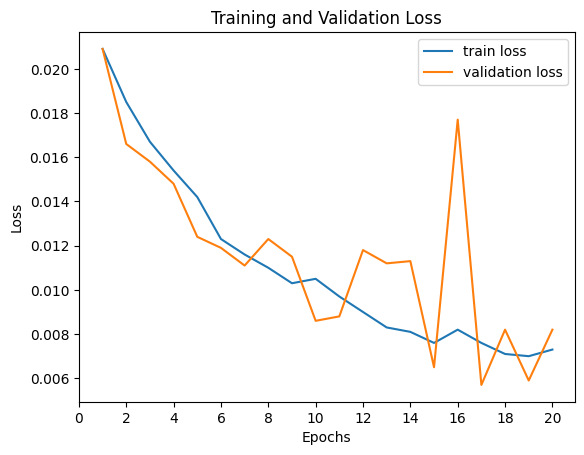

In [ ]:
num_epochs = range(1,21)
plt.plot(num_epochs, train_loss_short, label='train loss')
plt.plot(num_epochs, val_loss_short, label='validation loss')

plt.xticks(range(0, 21, 2))

plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

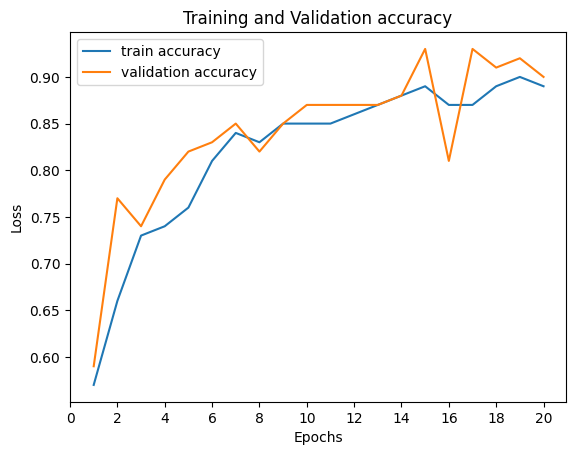

In [ ]:
num_epochs = range(1,21)
plt.plot(num_epochs, train_accuracy_short, label='train accuracy')
plt.plot(num_epochs, val_accuracy_short, label='validation accuracy')

plt.xticks(range(0, 21, 2))

plt.title('Training and Validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()